# Ejercicio 4: Modelo Probabilístico

## Objetivo de la práctica
- Comprender los componentes del modelo vectorial mediante cálculos manuales y observación directa.
- Aplicar el modelo de espacio vectorial con TF-IDF para recuperar documentos relevantes.
- Comparar la recuperación con BM25 frente a TF-IDF.
- Analizar visualmente las diferencias entre los modelos.
- Evaluar si los rankings generados son consistentes con lo que considerarías documentos relevantes.

## Parte 0: Carga del Corpus

In [1]:
from sklearn.datasets import fetch_20newsgroups

newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
newsgroupsdocs = newsgroups.data

In [2]:
newsgroupsdocs

["\n\nI am sure some bashers of Pens fans are pretty confused about the lack\nof any kind of posts about the recent Pens massacre of the Devils. Actually,\nI am  bit puzzled too and a bit relieved. However, I am going to put an end\nto non-PIttsburghers' relief with a bit of praise for the Pens. Man, they\nare killing those Devils worse than I thought. Jagr just showed you why\nhe is much better than his regular season stats. He is also a lot\nfo fun to watch in the playoffs. Bowman should let JAgr have a lot of\nfun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway. I was very disappointed not to see the Islanders lose the final\nregular season game.          PENS RULE!!!\n\n",
 'My brother is in the market for a high-performance video card that supports\nVESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:\n\n  - Diamond Stealth Pro Local Bus\n\n  - Orchid Farenheit 1280\n\n  - ATI Graphics Ultra Pro\n\n  - Any other high-per

### Limpieza del texto

Primero nos encargamos de los caracteres raros.

In [2]:
import re

def clean_text(text):
    text = text.replace('\n', ' ').replace('\t', ' ').replace(".", " ").replace(",", " ")
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

corpus = [clean_text(text) for text in newsgroupsdocs]

In [4]:
corpus

['I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the recent Pens massacre of the Devils Actually I am bit puzzled too and a bit relieved However I am going to put an end to nonPIttsburghers relief with a bit of praise for the Pens Man they are killing those Devils worse than I thought Jagr just showed you why he is much better than his regular season stats He is also a lot fo fun to watch in the playoffs Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway I was very disappointed not to see the Islanders lose the final regular season game PENS RULE',
 'My brother is in the market for a highperformance video card that supports VESA local bus with 12MB RAM Does anyone have suggestionsideas on Diamond Stealth Pro Local Bus Orchid Farenheit 1280 ATI Graphics Ultra Pro Any other highperformance VLB card Please post or email Thank you Matt',
 'Finally you said wha

In [5]:
len(corpus)

18846

Quitamos los documentos vacíos.

In [3]:
corpus = list(filter(lambda doc: doc and doc.strip(), corpus))

In [7]:
len(corpus)

18313

Todas las palabras deben ser capturadas en una lista.

In [5]:
words = set(" ".join(corpus).lower().split())

In [9]:
len(words)

149879

Ahora, utilizamos el Stemming para disminuir el tamaño de espacio de palabras. El Stemming vuelve a palabras complejas a su forma original o inicial.

In [6]:
from nltk.stem import porter
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")
words = set([stemmer.stem(word) for word in words])

In [11]:
len(words)

127061

Finalmente, realizamos una limpieza de palabras que no aportan valor.

In [7]:
# @title
!pip install wordfreq

In [7]:
from wordfreq import zipf_frequency

def is_valid_word(token):
  # muy largo y corto
  if len(token) < 2 or len(token) > 25:
      return False

  # si tiene muchos numeros y letras
  if sum(c.isdigit() for c in token) > len(token) / 2:
      return False

  # letras y numeros intercalados
  if re.search(r'[a-zA-Z]\d[a-zA-Z]', token):
      return False
  # frecuencia en ingles
  freq = zipf_frequency(token, 'en')
  if freq < 1.0 and not re.match(r'^\d{4}$', token):
    return False

  return True

words = [word for word in words if is_valid_word(word)]

In [14]:
len(words)

30730

Construimos una función para normalizar las palabras en base a los pasos anteriormente tomados.

In [9]:
def clean_words(words):
  words = set([word for word in words if is_valid_word(stemmer.stem(word))])

  return words

## Parte 1: Cálculo de TF, DF, IDF y TF-IDF

### Actividad
1. Utiliza el corpus cargado.
2. Construye la matriz de términos (TF), y calcula la frecuencia de documentos (DF)
3. Calcula TF-IDF utilizando sklearn.
4. Visualiza los valores en un DataFrame para analizar las diferencias entre los términos.

### Cálculo de TF-IDF de manera manual

Primero obtenemos TF de cada documento.

In [10]:
from collections import Counter
import numpy as np

def get_tf(doc, vocab_index):
  words = clean_words(doc.lower().split())
  total = len(words)
  counts = Counter(words)
  tf = np.zeros(len(vocab_index))

  if total == 0:
    return tf

  keys = vocab_index.keys()

  for word, count in counts.items():
    if word in keys:
      tf[vocab_index[word]] = count / total
  return np.array(tf)

Después IDF.

In [11]:
def get_idf(corpus, vocab_index):
  n_docs = len(corpus)
  df = np.zeros(len(vocab_index))

  for doc in corpus:
    words = clean_words(doc.lower().split())
    for w in words:
      if w in vocab_index:
        df[vocab_index[w]] += 1
  idf = np.log((n_docs + 1) / (df + 1)) + 1
  return idf

Finalmente TF-IDF.

In [12]:
def get_tf_idf(tf, idf):
  return tf * idf

Ahora calculamos las matrices para nuestro corpus. Utilizamos un índice para disminuir el costo computacional.

In [13]:
vocab_index = {word: index for index, word in enumerate(words)}

In [14]:
tf = np.array([get_tf(doc, vocab_index) for doc in corpus])

In [15]:
idf = get_idf(corpus, vocab_index)

In [16]:
tf_idf = get_tf_idf(tf, idf)

In [23]:
tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Construimos un diccionario para visualizar los datos mediante la librería pandas.

In [17]:
import pandas as pd

df = pd.DataFrame(tf_idf, columns=words)

In [ ]:
df.value_counts()

### Cálculo de TF-IDF usando sklearn

In [9]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordfreq import zipf_frequency

def limpiar_token(token):
  if not re.match(r'^[a-zA-Z0-9]+$', token):
    return False
  if len(token) < 2 or len(token) > 25:
    return False
  if sum(c.isdigit() for c in token) > len(token) / 2:
    return False
  if re.search(r'[a-zA-Z]\d[a-zA-Z]', token):
    return False

  if zipf_frequency(token, 'en') < 1.0:
    return False
  return True

def mi_tokenizador(texto):
    tokens = re.findall(r'\b\w+\b', texto.lower())
    return [t for t in tokens if limpiar_token(t)]

vectorizador = TfidfVectorizer(tokenizer=mi_tokenizador)

tf_idf = vectorizador.fit_transform(corpus)
terminos = vectorizador.get_feature_names_out()

df = pd.DataFrame(tf_idf.todense(), columns=terminos)
df


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000miles,000plus,000usd,00mhz,00us,0a,0b,0c,0d,0e,...,zwarte,zwingli,zwischen,zx,zy,zygon,zyxel,zz,zzzs,zzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18309,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18311,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Parte 2: Ranking de documentos usando TF-IDF

### Actividad

1. Dada una consulta, construye el vector de consulta
2. Calcula la similitud coseno entre la consulta y cada documento usando los vectores TF-IDF
3. Genera un ranking de los documentos ordenados por relevancia.
4. Muestra los resultados en una tabla.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def rank_documents(query, tfidf_matrix, vectorizer, corpus):
  # query
  query_vector = vectorizer.transform([query])

  # coseno
  cosine_sim = cosine_similarity(query_vector, tfidf_matrix).flatten()

  ranking = np.argsort(-cosine_sim)

  results = pd.DataFrame({
    'Documento': [corpus[i] for i in ranking],
    'Similaridad': cosine_sim[ranking]
  })

  return results


In [11]:
query = "vegetarian onion diet"
results_df = rank_documents(query, tf_idf, vectorizador, corpus)

print("TF-IDF rank del query:", query)
print(results_df)

TF-IDF rank del query: vegetarian onion diet
                                               Documento  Similaridad
0      Not sure of this but I think some millipedes c...     0.178475
1      Millipedes I understand are vegetarian and the...     0.163694
2      Need Diet for Diverticular Disease and ideas f...     0.151149
3      If one is a vegan a vegetarian taht eats no an...     0.150996
4      I remember hearing a few years back about a ne...     0.149680
...                                                  ...          ...
18308  Not in isolated ground recepticles usually an ...     0.000000
18309  I just installed a DX266 CPU in a clone mother...     0.000000
18310  Wouldnt this require a hypersphere In 3space 4...     0.000000
18311  After a tip from Gary Crum crumfcom cc utah ed...     0.000000
18312  I am sure some bashers of Pens fans are pretty...     0.000000

[18313 rows x 2 columns]


## Parte 3: Ranking con BM25

### Actividad

1. Implementa un sistema de recuperación usando el modelo BM25.
2. Usa la misma consulta del ejercicio anterior.
3. Calcula el score BM25 para cada documento y genera un ranking.
4. Compara manualmente con el ranking de TF-IDF.

In [8]:
from collections import Counter
import math
import numpy as np
import pandas as pd


def tokenize_and_stem(text):
    cleaned_text = clean_text(text)
    tokens = cleaned_text.lower().split()
    stemmed_and_filtered_tokens = [
        stemmer.stem(token) for token in tokens if is_valid_word(stemmer.stem(token))
    ]
    return stemmed_and_filtered_tokens

tokenized_corpus = [tokenize_and_stem(doc) for doc in corpus]


def calculate_idf_bm25(tokenized_corpus):
    df = Counter()
    N = len(tokenized_corpus)
    for doc_tokens in tokenized_corpus:
        for term in set(doc_tokens):
            df[term] += 1

    idf = {}
    for term, doc_count in df.items():
        idf[term] = math.log((N - doc_count + 0.5) / (doc_count + 0.5) + 1)
    return idf

def calculate_bm25_score(query_tokens, doc_tokens, idf, avgdl, k1=1.5, b=0.75):
    score = 0
    doc_len = len(doc_tokens)
    doc_term_counts = Counter(doc_tokens)

    for q_term in query_tokens:
        if q_term not in idf:
            continue

        f_td = doc_term_counts[q_term]

        idf_val = idf[q_term]

        numerator = f_td * (k1 + 1)
        denominator = f_td + k1 * (1 - b + b * (doc_len / avgdl))

        score += idf_val * (numerator / denominator)
    return score

idf_bm25 = calculate_idf_bm25(tokenized_corpus)

N_bm25 = len(tokenized_corpus)
avgdl_bm25 = sum(len(doc) for doc in tokenized_corpus) / N_bm25


def rank_documents_manual_bm25(query, tokenized_corpus, original_corpus, idf, avgdl, k1=1.5, b=0.75):
    query_tokens = tokenize_and_stem(query)

    scores = []
    for i, doc_tokens in enumerate(tokenized_corpus):
        score = calculate_bm25_score(query_tokens, doc_tokens, idf, avgdl, k1, b)
        scores.append(score)

    ranked_indices = np.argsort(scores)[::-1]

    results = pd.DataFrame({
        'Documento': [original_corpus[i] for i in ranked_indices],
        'Score BM25': [scores[i] for i in ranked_indices]
    })
    return results

query = "vegetarian onion diet"
bm25_manual_results_df = rank_documents_manual_bm25(
    query, tokenized_corpus, corpus, idf_bm25, avgdl_bm25
)

print("BM25 rank del query (implementación manual):", query)
print(bm25_manual_results_df)

BM25 rank del query (implementación manual): vegetarian onion diet
                                               Documento  Score BM25
0      If one is a vegan a vegetarian taht eats no an...   19.935649
1      Not sure of this but I think some millipedes c...   14.698892
2                          yup with onions of all things   14.654485
3      Nonsmoking roommate needed to sublet 1BR in 2B...   11.454470
4      Millipedes I understand are vegetarian and the...   11.405806
...                                                  ...         ...
18308  Article 31 of alt graphics Newsgroups alt grap...    0.000000
18309  Well yeah but unlike TIFF they all do substant...    0.000000
18310  I know this is kinda off the subject of sci sp...    0.000000
18311  For Sale VCR Samsung VR2610 basic 2 head machi...    0.000000
18312  Theres a pretty good article in the the March ...    0.000000

[18313 rows x 2 columns]


Comparación manual con TF-IDF

In [16]:
results_df.iloc[0,1]

np.float64(0.1784745915181479)

In [17]:
bm25_manual_results_df.iloc[0,1]

np.float64(19.935648979939028)

## Parte 4: Comparación visual entre TF-IDF y BM25

### Actividad

1. Utiliza un gráfico de barras para visualizar los scores obtenidos por cada documento según TF-IDF y BM25.
2. Compara los rankings visualmente.
3. Identifica: ¿Qué documentos obtienen scores más altos en un modelo que en otro?
4. Sugiere: ¿A qué se podría deber esta diferencia?

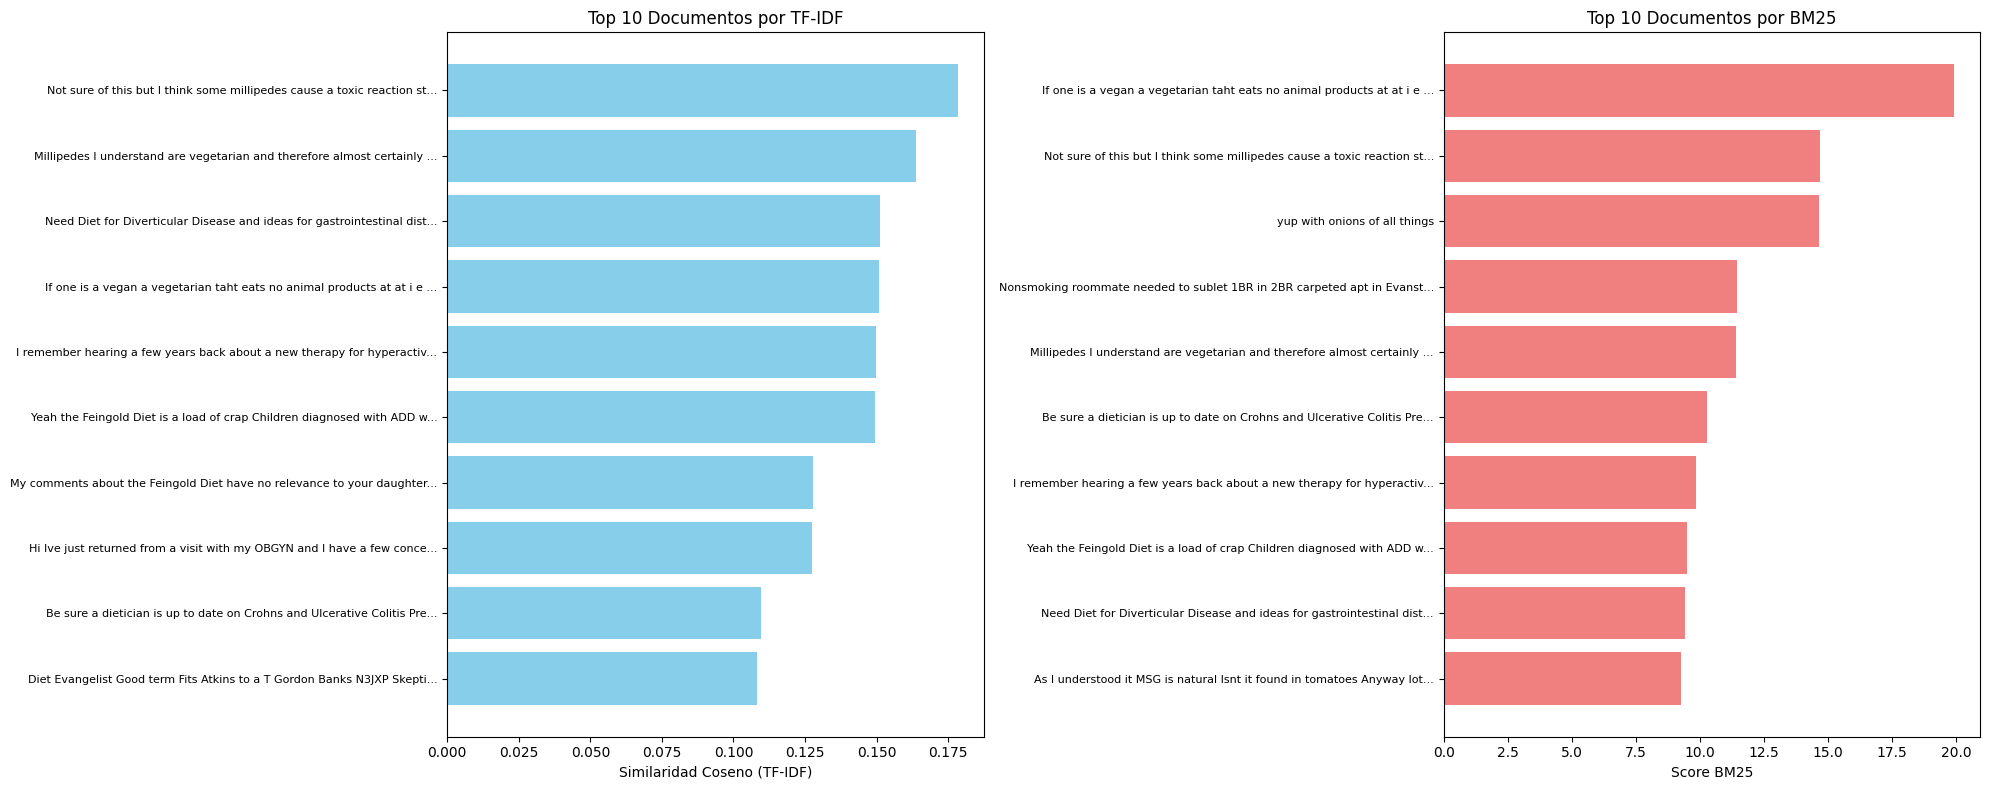

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

top_n_tfidf = results_df.head(10)

top_n_bm25 = bm25_manual_results_df.head(10)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

axes[0].barh(top_n_tfidf['Documento'].apply(lambda x: x[:70] + '...' if len(x) > 70 else x), top_n_tfidf['Similaridad'], color='skyblue')
axes[0].set_xlabel('Similaridad Coseno (TF-IDF)')
axes[0].set_title('Top 10 Documentos por TF-IDF')
axes[0].invert_yaxis()
axes[0].tick_params(axis='y', labelsize=8)


axes[1].barh(top_n_bm25['Documento'].apply(lambda x: x[:70] + '...' if len(x) > 70 else x), top_n_bm25['Score BM25'], color='lightcoral')
axes[1].set_xlabel('Score BM25')
axes[1].set_title('Top 10 Documentos por BM25')
axes[1].invert_yaxis()
axes[1].tick_params(axis='y', labelsize=8)

plt.tight_layout()
plt.show()

Pregunta 3: El documento con mas score en TF-IDF es el segundo con BM25 mientras que el documento con mas score en BM25 es el cuarto con TF-IDF

Pregunta 4: AL Implementamar manualmente el algoritmo BM25 lo aplicamos a una consulta y comparamos sus resultados con los de TF-IDF. La comparación mostró rankings diferentes, explicado por las distintas formas en que BM25 realiza saturación de términos, normalización de longitud mientras que con TF-IDF se realiza escalado lineal y menos sensible a la longitud.

## Parte 5: Evaluación con consulta relevante

### Actividad

1. Elige una consulta y define qué documentos del corpus deberían considerarse relevantes.
2. Evalúa Precision@3 o MAP para los rankings generados con TF-IDF y BM25.
3. Responde: ¿Cuál modelo da mejores resultados respecto a tu criterio de relevancia?

In [20]:
query2 = "few years back"
results_df_2 = rank_documents(query2, tf_idf, vectorizador, corpus)

print("TF-IDF rank del query:", query2)
print(results_df_2)

TF-IDF rank del query: few years back
                                               Documento  Similaridad
0      forgive any inaccuracies i deleted the origina...     0.284635
1      And wont they have to change their name to the...     0.258831
2      Did the Russian spacecrafts on the illfated Ph...     0.234233
3      What problems have you had with UHC I have bee...     0.231543
4      Not the first RFK olim DC Stadium was built 2 ...     0.212071
...                                                  ...          ...
18308  Not in isolated ground recepticles usually an ...     0.000000
18309  My brother is in the market for a highperforma...     0.000000
18310  Wouldnt this require a hypersphere In 3space 4...     0.000000
18311  After a tip from Gary Crum crumfcom cc utah ed...     0.000000
18312  I am sure some bashers of Pens fans are pretty...     0.000000

[18313 rows x 2 columns]


In [22]:
query2 = "few years back"
bm25_manual_results_df_2 = rank_documents_manual_bm25(
    query2, tokenized_corpus, corpus, idf_bm25, avgdl_bm25
)

print("BM25 rank del query (implementación manual):", query2)
print(bm25_manual_results_df_2)

BM25 rank del query (implementación manual): few years back
                                               Documento  Score BM25
0      forgive any inaccuracies i deleted the origina...   11.574602
1      Did the Russian spacecrafts on the illfated Ph...   11.056444
2      And wont they have to change their name to the...   11.056444
3      What is NASAs annual budget This year will do ...   11.019270
4      I remember hearing a few years back about a ne...   10.987768
...                                                  ...         ...
18308  Just saw a new commercial by the NRA It starts...    0.000000
18309  Please excuse the interruption I am seeking pr...    0.000000
18310  Big deal If you are a legitimate law enforceme...    0.000000
18311  Cannondale 3 0 Road Bike 56 cm Bright Blue Col...    0.000000
18312  Okay Ill bite How can OBP be lower than battin...    0.000000

[18313 rows x 2 columns]


Actividad 2 y 3

In [23]:
import numpy as np


def get_mock_relevant_doc_indices(query, corpus):
    relevant_phrases = [
        "few years back", "years ago", "some years ago", "many years ago",
        "a few years ago", "back in high school", "in the past", "previously reported"
    ]
    if query not in relevant_phrases:
        relevant_phrases.append(query)

    relevant_indices = set()
    for i, doc in enumerate(corpus):
        doc_lower = doc.lower()
        for phrase in relevant_phrases:
            if phrase in doc_lower:
                relevant_indices.add(i)
                break
    return sorted(list(relevant_indices))

query2 = "few years back"
relevant_docs_for_query2 = get_mock_relevant_doc_indices(query2, corpus)

print(f"Número de documentos relevantes mock para '{query2}': {len(relevant_docs_for_query2)}")


def calculate_precision_at_k(ranked_list_df, relevant_docs_indices, k=3):
    retrieved_doc_texts = ranked_list_df['Documento'].head(k).tolist()
    retrieved_indices = []
    for text in retrieved_doc_texts:
        try:
            idx = corpus.index(text)
            retrieved_indices.append(idx)
        except ValueError:
            pass

    hits = 0
    for idx in retrieved_indices:
        if idx in relevant_docs_indices:
            hits += 1

    if k == 0: return 0.0
    return hits / k


def calculate_average_precision(ranked_list_df, relevant_docs_indices):
    retrieved_doc_texts = ranked_list_df['Documento'].tolist()
    retrieved_indices = []
    for text in retrieved_doc_texts:
        try:
            idx = corpus.index(text)
            retrieved_indices.append(idx)
        except ValueError:
            pass

    ap = 0.0
    relevant_count = 0
    for i, doc_idx in enumerate(retrieved_indices):
        if doc_idx in relevant_docs_indices:
            relevant_count += 1
            precision_at_i = relevant_count / (i + 1)
            ap += precision_at_i

    if relevant_count == 0:
        return 0.0
    return ap / relevant_count

p3_tfidf = calculate_precision_at_k(results_df_2, relevant_docs_for_query2, k=3)
ap_tfidf = calculate_average_precision(results_df_2, relevant_docs_for_query2)

print(f"\n--- Evaluación TF-IDF para la consulta '{query2}' ---")
print(f"Precision@3 (TF-IDF): {p3_tfidf:.4f}")
print(f"Average Precision (TF-IDF): {ap_tfidf:.4f}")

p3_bm25 = calculate_precision_at_k(bm25_manual_results_df_2, relevant_docs_for_query2, k=3)
ap_bm25 = calculate_average_precision(bm25_manual_results_df_2, relevant_docs_for_query2)

print(f"\n--- Evaluación BM25 para la consulta '{query2}' ---")
print(f"Precision@3 (BM25): {p3_bm25:.4f}")
print(f"Average Precision (BM25): {ap_bm25:.4f}")


print("\n--- Conclusión ---")
if ap_tfidf > ap_bm25:
    print("Según Average Precision, TF-IDF tiene un rendimiento ligeramente mejor para esta consulta.")
elif ap_bm25 > ap_tfidf:
    print("Según Average Precision, BM25 tiene un rendimiento ligeramente mejor para esta consulta.")
else:
    print("Según Average Precision, ambos modelos tienen un rendimiento similar para esta consulta.")

if p3_tfidf > p3_bm25:
    print("En Precision@3, TF-IDF también es mejor.")
elif p3_bm25 > p3_tfidf:
    print("En Precision@3, BM25 también es mejor.")
else:
    print("En Precision@3, ambos modelos son similares.")

Número de documentos relevantes mock para 'few years back': 548

--- Evaluación TF-IDF para la consulta 'few years back' ---
Precision@3 (TF-IDF): 1.0000
Average Precision (TF-IDF): 0.1752

--- Evaluación BM25 para la consulta 'few years back' ---
Precision@3 (BM25): 1.0000
Average Precision (BM25): 0.1827

--- Conclusión ---
Según Average Precision, BM25 tiene un rendimiento ligeramente mejor para esta consulta.
En Precision@3, ambos modelos son similares.
